Creates dataframe of individual fight data using the information in the json files

In [221]:
import pandas as pd 
import json 
import os 
import numpy as np

folder_path = 'events'  
fight_rows = []

# Loop through all JSON files
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        with open(os.path.join(folder_path, filename), 'r') as f:
            data = json.load(f)

        date = data.get("date")
        event = data.get("event")

        for key, fight in data.items():
            if isinstance(fight, dict) and 'fighter1' in fight and 'fighter2' in fight:
                f1_data = fight.get('fighter1_fight_data') or {}
                f2_data = fight.get('fighter2_fight_data') or {}

                row = {
                    'event': event,
                    'date': date,
                    'fight_name': fight.get('name'),
                    'f1': fight.get('fighter1'),
                    'f2': fight.get('fighter2'),
                    'winner': fight.get('winner'),
                    'method': fight.get('method'),
                    'fight_length': fight.get('fight_length')
                }

                # Add all fighter1 stats with prefix f1_
                for stat, value in f1_data.items():
                    row[f'f1_{stat}'] = value

                # Add all fighter2 stats with prefix f2_
                for stat, value in f2_data.items():
                    row[f'f2_{stat}'] = value

                fight_rows.append(row)

# Create DataFrame
fight_df = pd.DataFrame(fight_rows)
fight_df['date'] = pd.to_datetime(fight_df['date'], errors='coerce')

fight_df.sort_values(by='date', inplace=True)
fight_df.to_csv('fight_df.csv')

Create a new dataframe of features to analyze

In [222]:

def calculate_fighter_historical_averages(fight_df):
    """
    Calculate historical averages for each fighter prior to each fight.
    
    Args:
        fight_df: DataFrame with fight data
    
    Returns:
        DataFrame with historical averages added for each fighter
    """
    
    # Ensure the dataframe is sorted by date
    fight_df = fight_df.sort_values('date').reset_index(drop=True)
    
    # Define the stat columns we want to calculate averages for
    stat_columns = [
        'kd', 'sig_str_landed', 'sig_str_att', 'str_landed', 'str_att',
        'td_comp', 'td_att', 'sub_att', 'ctrl_time'
    ]
    
    # Create a list to store results
    results = []
    
    # Process each fight
    for idx, fight in fight_df.iterrows():
        fight_result = fight.copy()
        
        # Get fights prior to current fight for each fighter
        prior_fights = fight_df.iloc[:idx]  # All fights before current fight
        
        # Calculate averages for fighter 1 (f1)
        f1_prior = get_fighter_prior_fights(prior_fights, fight['f1'])
        for stat in stat_columns:
            f1_col = f'f1_{stat}'
            avg_col = f'f1_avg_{stat}'
            fight_result[avg_col] = f1_prior[f1_col].mean() if len(f1_prior) > 0 else np.nan
        
        # Calculate averages for fighter 2 (f2)
        f2_prior = get_fighter_prior_fights(prior_fights, fight['f2'])
        for stat in stat_columns:
            f2_col = f'f2_{stat}'
            avg_col = f'f2_avg_{stat}'
            fight_result[avg_col] = f2_prior[f2_col].mean() if len(f2_prior) > 0 else np.nan
        
        results.append(fight_result)
    
    return pd.DataFrame(results)

def get_fighter_prior_fights(prior_fights_df, fighter_name):
    """
    Get all prior fights for a specific fighter (as either f1 or f2).
    """
    # Fighter could be in either f1 or f2 position
    f1_fights = prior_fights_df[prior_fights_df['f1'] == fighter_name].copy()
    f2_fights = prior_fights_df[prior_fights_df['f2'] == fighter_name].copy()
    
    # For f2 fights, we need to swap the column names to match f1 format
    if len(f2_fights) > 0:
        # Create a mapping to swap f1/f2 stats
        stat_columns = [
            'kd', 'sig_str_landed', 'sig_str_att', 'str_landed', 'str_att',
            'td_comp', 'td_att', 'sub_att', 'ctrl_time'
        ]
        
        for stat in stat_columns:
            f1_col = f'f1_{stat}'
            f2_col = f'f2_{stat}'
            # Swap the values
            f2_fights[f1_col] = f2_fights[f2_col]
    
    # Combine all fights and return only the f1 columns (since we normalized everything to f1 format)
    all_fights = pd.concat([f1_fights, f2_fights], ignore_index=True)
    return all_fights

# Example usage:
# Make sure your fight_df has the correct column names and is loaded
# fight_df_with_averages = calculate_fighter_historical_averages(fight_df)

# You can also add additional metrics like win rate, finish rate, etc.
def add_additional_fighter_metrics(fight_df_with_averages):
    """
    Add additional historical metrics like win rate, finish rate, etc.
    """
    results = []
    
    for idx, fight in fight_df_with_averages.iterrows():
        fight_result = fight.copy()
        
        # Get fights prior to current fight
        prior_fights = fight_df_with_averages.iloc[:idx]
        
        # Calculate win rates for both fighters
        for fighter_col, prefix in [('f1', 'f1_'), ('f2', 'f2_')]:
            fighter_name = fight[fighter_col]
            
            # Get prior fights for this fighter
            fighter_prior = get_fighter_prior_fights(prior_fights, fighter_name)
            
            if len(fighter_prior) > 0:
                # Win rate
                wins = (fighter_prior['winner'] == fighter_name).sum()
                fight_result[f'{prefix}win_rate'] = wins / len(fighter_prior)
                
                # Finish rate (non-decision wins)
                finishes = fighter_prior[
                    (fighter_prior['winner'] == fighter_name) & 
                    (fighter_prior['method'].isin(['KO/TKO', 'Submission']))
                ].shape[0]
                fight_result[f'{prefix}finish_rate'] = finishes / len(fighter_prior) if len(fighter_prior) > 0 else 0
                
                # Total fights
                fight_result[f'{prefix}total_fights'] = len(fighter_prior)
            else:
                fight_result[f'{prefix}win_rate'] = np.nan
                fight_result[f'{prefix}finish_rate'] = np.nan
                fight_result[f'{prefix}total_fights'] = 0
        
        results.append(fight_result)
    
    return pd.DataFrame(results)

# Complete pipeline:
# 1. Calculate basic stat averages
fight_df_with_averages = calculate_fighter_historical_averages(fight_df)

# 2. Add additional metrics
final_df = add_additional_fighter_metrics(fight_df_with_averages)

final_df.to_csv('final_df.csv')




Get the fights where both fighters have fought atleast 3 times 

In [232]:
final_df['label'] = (final_df['winner'] == final_df['f1']).astype(int)
features_df = pd.DataFrame()


keep_columns = [
    'label',
    'f1_avg_kd',
    'f1_avg_sig_str_landed',
    'f1_avg_sig_str_att',
    'f1_avg_str_landed',
    'f1_avg_str_att',
    'f1_avg_td_comp',
    'f1_avg_td_att',
    'f1_avg_sub_att',
    'f1_avg_ctrl_time',
    'f2_avg_kd',
    'f2_avg_sig_str_landed',
    'f2_avg_sig_str_att',
    'f2_avg_str_landed',
    'f2_avg_str_att',
    'f2_avg_td_comp',
    'f2_avg_td_att',
    'f2_avg_sub_att',
    'f2_avg_ctrl_time',
    'f1_win_rate',
    'f1_finish_rate',
    'f1_total_fights',
    'f2_win_rate',
    'f2_finish_rate',
    'f2_total_fights'
]


features_df = final_df[keep_columns]
features_df.to_csv('features_df.csv')


Split the data

In [233]:
from sklearn.model_selection import train_test_split

X = features_df.drop(columns='label')
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6550652579241765
              precision    recall  f1-score   support

           0       0.51      0.24      0.33       561
           1       0.68      0.88      0.77      1048

    accuracy                           0.66      1609
   macro avg       0.60      0.56      0.55      1609
weighted avg       0.62      0.66      0.62      1609



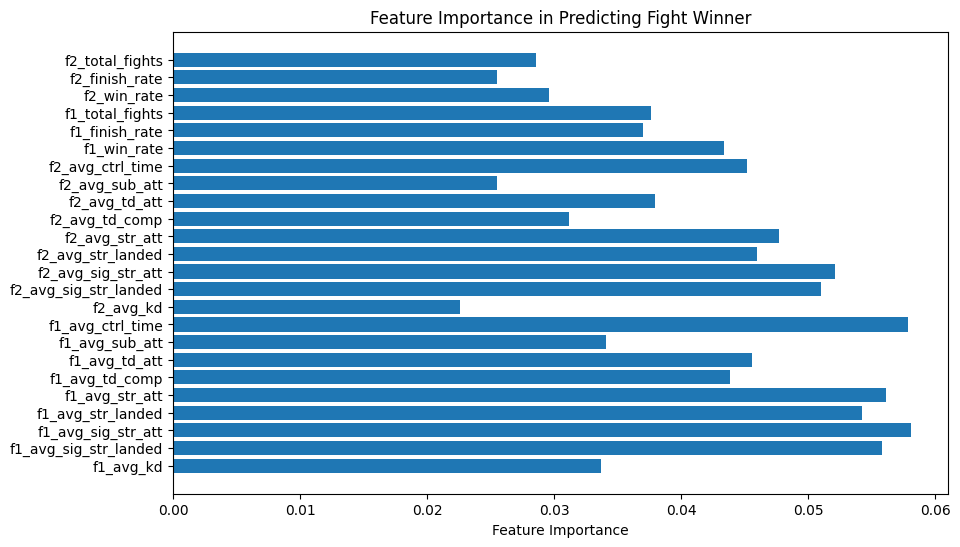

In [238]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Fight Winner")
plt.show()